# Part 1 

In [163]:
from tqdm import tqdm
import pickle
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import subprocess
import numpy as np
import torch
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import os
from torch_geometric.loader import DataLoader
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from collections import Counter
from torch_geometric.data import Data, Dataset
import json
import os
import pandas as pd
import pandas as pd
from rdkit import Chem
import torch
import numpy as np
from torch.utils.data import Dataset
import pickle
from collections import defaultdict
from pathlib import Path
import torch.nn.functional as F
import pickle
from tqdm import tqdm
import pickle
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import subprocess
import numpy as np
import torch
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import os
from torch_geometric.loader import DataLoader
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from collections import Counter
from torch_geometric.data import Data, Dataset
import json
import os
import pandas as pd
import pandas as pd
from rdkit import Chem
import torch
import numpy as np
from torch.utils.data import Dataset
import pickle
from collections import defaultdict
from pathlib import Path
import torch.nn.functional as F
import pickle
import json 

In [164]:
%run ../Config.ipynb
config = Config()
pdbs = os.listdir(config.set)
nposes = config.docking_params['nposes']
batch_size  = config.model_args['batch_size']
path_scripts = Path(os.getcwd())
num_epochs = config.model_args['epochs']
num_folds = config.model_args['nfolds']
patience = config.model_args['patience']  # Set your desired patience value
binana_executable = config.executables['binana']

#### Functions 

In [165]:
def filter_and_print_label_distribution(dataset_list_final):
    filtered_data_list_num_nodes = [data for data in dataset_list_final if data.num_nodes > 0]
    filtered_data_list_descriptors = [data for data in filtered_data_list_num_nodes if data.x_s.shape[0] > 0 and data.x_t.shape[0] > 0]
    filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[0, 2].isnan()] 
    filtered_data_list = filtered_data_list_descriptors.copy()
    
    label_distribution = dict(Counter([label.y.tolist() for label in filtered_data_list]))
    amount_of_graphs_used_to_train = len(filtered_data_list)
    
    print("Label Distribution:")
    for label, count in label_distribution.items():
        print(f"Label {label}: {count}")
    
    print(f"Amount of Graphs Used to Train: {amount_of_graphs_used_to_train}")
    
    return filtered_data_list

In [166]:
def save_list_to_file(data_list, config, name):
    with open(f'{config.data}/{name}', 'wb') as file:
        pickle.dump(data_list, file)
        print(f'Saved {name} with success!')

def open_file(config, name):
    with open(f'../Datahub/Data/{name}', 'rb') as file:
        bipartite_data = pickle.load(file) 
    return bipartite_data

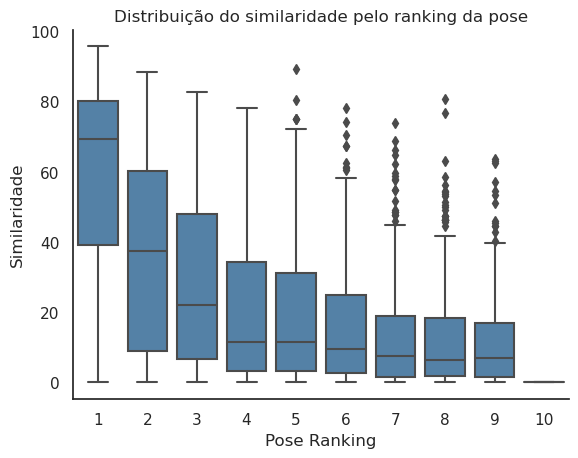

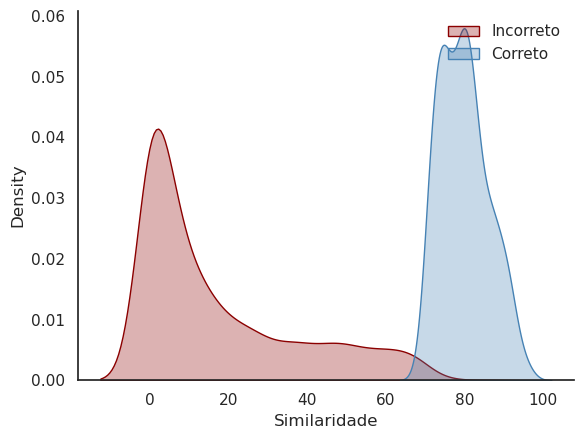

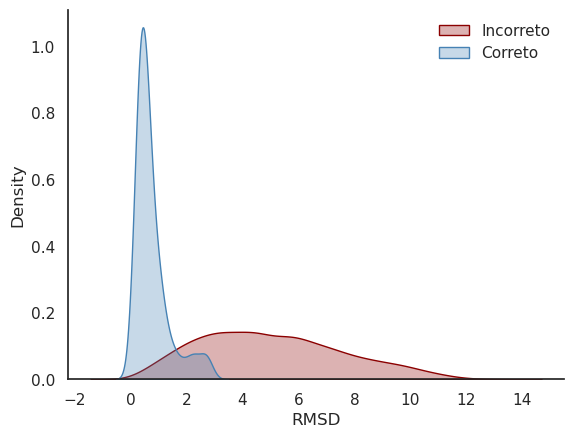

/tmp/ipykernel_17124/4027079687.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lepton = lepton.append({"pdb":pdb, "class":class_}, ignore_index = True)
/tmp/ipykernel_17124/4027079687.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lepton = lepton.append({"pdb":pdb, "class":class_}, ignore_index = True)
/tmp/ipykernel_17124/4027079687.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lepton = lepton.append({"pdb":pdb, "class":class_}, ignore_index = True)
/tmp/ipykernel_17124/4027079687.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lepton = lepton.append({"pdb":pdb, "class":class_}, ignore_index = True)
/tmp/ipykernel_1

AttributeError: 'int' object has no attribute 'round'

AttributeError: 'int' object has no attribute 'round'

In [167]:
%run Label.ipynb
label = pd.read_json(f"{config.data}/label.json").fillna(0)
len(label.columns)

#### Get_dataset

In [ ]:
with open(f'{config.root}/{config.project_name}/{config.dicts}/combined_dicts_atoms_prop.pkl','rb') as f:
        combined_dict_atoms_prop = pickle.load(f)

In [168]:
%%time
class Get_dataset():
    def __init__(self, pdbs, lig_atoms_prop, rec_atoms_prop, df_dict, subsample=None, preprocessed_protgraph=False):
        self.pdbs = pdbs
        self.lig_atoms_prop = combined_dict_atoms_prop['lig_atoms_prop']
        self.rec_atoms_prop = combined_dict_atoms_prop['rec_atoms_prop']
        self.df_dict = combined_dict_atoms_prop['df_dict']
        self.protgraph_dict = self.get_unique_prot_graphs()
        self.preprocessed_protgraph=preprocessed_protgraph
        self.subsample = subsample 

        
    def map_node_names_to_indices(self, edge_index):
        unique_node_names_0, node_name_to_index_0 = torch.unique(edge_index[0], sorted=True, return_inverse=True)
        unique_node_names_1, node_name_to_index_1 = torch.unique(edge_index[1], sorted=True, return_inverse=True)
    
        # Map the node names to their corresponding indices separately for edge_index[0] and edge_index[1]
        updated_edge_index_0 = node_name_to_index_0.view(1, -1)
        updated_edge_index_1 = node_name_to_index_1.view(1, -1)
    
        # Combine the updated edge indices back into the same format as edge_index
        updated_edge_index = torch.cat((updated_edge_index_0, updated_edge_index_1), dim=0)
    
        return updated_edge_index
        
    def get_unique_prot_graphs(self):
        protgraph_dict = {}
        failed_protgraph = []

        for pdb in self.pdbs:
            protgraph_dict[pdb] = {}
            for pose in range(1, nposes + 1):
                try:
                    x_s = torch.tensor(np.array(self.lig_atoms_prop[pdb][pose].iloc[:, 1:].astype("float32")))
                    x_t = torch.tensor(np.array(self.rec_atoms_prop[pdb][pose].iloc[:, 1:].astype("float32")))
                    edge_index = torch.tensor(np.array([self.df_dict[pdb][pose]["ligand_atom_index"].astype("int64"),
                                                    self.df_dict[pdb][pose]["receptor_atom_index"].astype("int64")]))
                
                    edge_index = self.map_node_names_to_indices(edge_index)
                    distances = torch.tensor(np.array(self.df_dict[pdb][pose]['distance']).astype("float32"))
                    #print('x_s: ', x_s)
                    protgraph_dict[pdb][pose] = {'x_s': x_s, # Ligand
                                             'x_t': x_t, # Receptor
                                             'edge_index': edge_index,
                                             'edge_attr': distances,
                                             }
                except Exception as e:
                    #print('Error')
                    continue
        return protgraph_dict


    def process(self):
        print('processessing....')
        if self.preprocessed_protgraph:
            with open(f'{config.root}/{config.project_name}/{config.dicts}/protgraph_dict.pkl','rb') as f:
               protgraph_dict = pickle.load(f)
        else:
            protgraph_dict = self.get_unique_prot_graphs()
            with open(f'{config.root}/{config.project_name}/{config.dicts}/protgraph_dict.pkl','wb') as f:
                pickle.dump(protgraph_dict,f)
         
        for pdb in tqdm(pdbs, desc = 'PDBs'):
            for pose in range(1, nposes + 1): 

                try: 
                             #  self.protgraph_dict[pdb][pose]
                    protgraph = protgraph_dict[pdb][pose] ### Needs alteration to open saved dict, lets got with it righ now
    
                    interaction_id = str(pdb) + "_" + str(pose)                 
         
                    x_s, x_t, edge_index, edge_attr= protgraph['x_s'], protgraph['x_t'], protgraph['edge_index'],protgraph['edge_attr']
    
                    #y = torch.randint(2, (1,), dtype=torch.float32)
                    try:
                        y = torch.tensor(label[pdb][pose], dtype=torch.float32)
                    except Exception as e:
                        print(f"Error: {e}")
                        continue
                    #y = label[pdb][pose].astype("float32")
                    data = BipartiteData(edge_index=edge_index, x_s=x_s, x_t=x_t, y=y, edge_attr = edge_attr, pdb = pdb, pose = pose)
                    #print(f'saving data {config.processed_dir}')
                    torch.save(data, os.path.join(config.processed_dir, f'data_{interaction_id}.pt'))  

                except Exception as e:
                    #print(f"Error: {e}")
                    continue

    
    def processed_file_names(self):
        datalist =   [torch.load(os.path.join(config.processed_dir, f'{filename}')) for filename in os.listdir(config.processed_dir)]
        random.shuffle(datalist)
        return datalist

   # def __len__(self):
   #     return len(protgraph_dict)  ###
   # 
   #def __getitem__(self, index):
   #    pdb = self.pdbs[index]
   #    pose = 1  # You may need to modify this
   #    data_sample = self.protgraph_dict[pdb][pose]
   #    return data_sample

  

dataset = Get_dataset(pdbs, combined_dict_atoms_prop['lig_atoms_prop'], combined_dict_atoms_prop['rec_atoms_prop'], combined_dict_atoms_prop['df_dict'])

CPU times: user 18.7 ms, sys: 228 µs, total: 18.9 ms
Wall time: 20.8 ms


In [169]:
#for filename in os.listdir(config.processed_dir):
#    print(filename)

#### BipartiteData

In [170]:
class BipartiteData(Data):
    def __init__(self, edge_index=None, x_s=None, x_t=None, y=None, edge_attr=None, pdb = None, pose = None):
        super().__init__()
        self.edge_index = edge_index
        self.x_s = x_s
        self.x_t = x_t
        self.y = y
        self.edge_attr = edge_attr  # Add edge_attr attribute
        #self.num_nodes = len(set(edge_index[0].tolist())) +  len(set(edge_index[1].tolist()))
        self.num_nodes = (x_s.size(0) if x_s is not None else 0) + (x_t.size(0) if x_t is not None else 0)
        self.pdb = pdb
        self.pose = pose
    
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index':
            return torch.tensor([[self.x_s.size(0)], [self.x_t.size(0)]])
        else:
            return super().__inc__(key, value, *args, **kwargs)

#### Dataset_list

In [171]:
%%time
dataset.process()
dataset_list = dataset.processed_file_names()

processessing....


PDBs: 100%|█████████████████████████████████| 284/284 [00:00<00:00, 6902.48it/s]


CPU times: user 1.4 s, sys: 92.2 ms, total: 1.49 s
Wall time: 1.53 s


In [172]:
len(dataset_list)

2840

In [173]:
#config.node_descriptors

In [174]:
for test in dataset_list:
    if test.pdb == '4eor':
        print(test)

BipartiteData(edge_index=[2, 0], x_s=[0, 8], x_t=[0, 8], y=0.0, edge_attr=[0], num_nodes=0, pdb='4eor', pose=10)
BipartiteData(edge_index=[2, 78], x_s=[78, 8], x_t=[78, 8], y=0.0, edge_attr=[78], num_nodes=156, pdb='4eor', pose=4)
BipartiteData(edge_index=[2, 83], x_s=[83, 8], x_t=[83, 8], y=0.0, edge_attr=[83], num_nodes=166, pdb='4eor', pose=8)
BipartiteData(edge_index=[2, 80], x_s=[80, 8], x_t=[80, 8], y=0.0, edge_attr=[80], num_nodes=160, pdb='4eor', pose=3)
BipartiteData(edge_index=[2, 86], x_s=[86, 8], x_t=[86, 8], y=0.0, edge_attr=[86], num_nodes=172, pdb='4eor', pose=6)
BipartiteData(edge_index=[2, 105], x_s=[105, 8], x_t=[105, 8], y=1.0, edge_attr=[105], num_nodes=210, pdb='4eor', pose=2)
BipartiteData(edge_index=[2, 98], x_s=[98, 8], x_t=[98, 8], y=0.0, edge_attr=[98], num_nodes=196, pdb='4eor', pose=5)
BipartiteData(edge_index=[2, 88], x_s=[88, 8], x_t=[88, 8], y=0.0, edge_attr=[88], num_nodes=176, pdb='4eor', pose=1)
BipartiteData(edge_index=[2, 61], x_s=[61, 8], x_t=[61, 8

In [175]:
dataset_list[6].x_t[0:10]

tensor([[0.0000, 0.0000, 3.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.1684],
        [0.0000, 0.0000, 3.0000, 3.0000, 0.0000, 0.0000, 0.0000, 0.1684],
        [0.0000, 0.0000, 3.0000, 3.0000, 0.0000, 0.0000, 0.0000, 0.1684],
        [0.0000, 0.0000, 3.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.1684],
        [0.0000, 0.0000, 3.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.1684],
        [0.0000, 3.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1684],
        [0.0000, 2.0000, 2.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.1684],
        [0.0000, 2.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1684],
        [0.0000, 0.0000, 3.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.1684],
        [0.0000, 3.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1684]])

In [176]:
pdb = '4j28'
pose = 7
ligand_path =   f"{config.set}/{pdb}/results/pose_{pose}.pdb"
protein_path =  f"{config.set}/{pdb}/{pdb}_protein_fixed.pdb"
molecule = Chem.MolFromPDBFile(protein_path, removeHs=False)
molecule

[15:23:31] Explicit valence for atom # 0 N, 5, is greater than permitted


# Part 2 

#### Saving dataset list

In [177]:
cut = 4
name = f"bipartite_rank_cut_4_REFINED_RAND_POSERANKtype2" 
name_encoded = f"bipartite_rank_cut_4_REFINED_RAND_POSERANKtype2" 

In [178]:
%%time
with open(f'{config.data}/{name}', 'wb') as file:
    pickle.dump(dataset_list, file)
    print('Saved with sucess!')

Saved with sucess!
CPU times: user 1.29 s, sys: 87.5 ms, total: 1.38 s
Wall time: 1.47 s


#### Opening dataset list

In [179]:
#name_temp = 'bipartite_data_no_pose_rank_cut_4_refined_set_encoded_RAND.pkl'
with open(f'{config.data}/{name}', 'rb') as file:
    dataset_list_opened = pickle.load(file)
len(dataset_list_opened)

2840

In [180]:
dataset_list_opened[0]

BipartiteData(edge_index=[2, 61], x_s=[61, 8], x_t=[61, 8], y=0.0, edge_attr=[61], num_nodes=122, pdb='3qgy', pose=7)

#### Filter data list 

In [181]:
filtered_data_list = filter_and_print_label_distribution(dataset_list_opened)

Label Distribution:
Label 0.0: 1979
Label 1.0: 146
Amount of Graphs Used to Train: 2125


In [182]:
len(filtered_data_list)

2125

#### Ordering the data 

In [1]:
#proper_order = list(pd.read_csv('/home/lbcb02/Workspace/BindRanker/BindRanker/Datahub/Data/depara_pdb_protein_name.csv').sort_values('Protein name')['PDB code'])

In [2]:
#len(set(pdbs) - set(proper_order))

In [3]:
#order_data = False
#def pdb_index(item):
#    try:
#        return proper_order.index(item.pdb)
#    except ValueError:
#        return float('inf')  # Return a very large value if PDb not found
#if order_data:
#    filtered_data_list = sorted(filtered_data_list, key=pdb_index)
#    

#### One-hot-enconding-Element_Name

In [186]:
import torch

def apply_one_hot_encoding_to_tensor(tensor, column_index, num_classes):
    column_data = tensor[:, column_index] 
     
    one_hot_encoded = torch.nn.functional.one_hot(column_data.to(torch.int64), num_classes=num_classes)
    tensor = torch.cat((tensor, one_hot_encoded.float()), dim=1)
    tensor = torch.cat((tensor[:, :column_index], tensor[:, column_index + 1:]), dim=1)
 
        
    return tensor

def apply_one_hot_encoding_to_data(data_list, column_index, num_classes):
    i = 0 
    for index, data in enumerate(data_list):
        try:
            data.x_s = apply_one_hot_encoding_to_tensor(data.x_s, column_index, num_classes)
            data.x_t = apply_one_hot_encoding_to_tensor(data.x_t, column_index, num_classes)
        except Exception as e:
            print('Error: ', e, 'index', index)
            i += 1
    print('Total erros: ', i )

In [187]:
apply_one_hot_encoding_to_data(filtered_data_list, column_index=1, num_classes=5)

Total erros:  0


In [188]:
print("Nº Dataset to train ", len(filtered_data_list))

Nº Dataset to train  2125


#### Randomizing 

In [189]:
#with open(f'{config.data}/{file_to_randomize}.pkl', 'rb') as file:
#    filtered_data_list = pickle.load(file) 
random.shuffle(filtered_data_list)

In [190]:
Counter([data.y.tolist() for data in filtered_data_list])

Counter({0.0: 1979, 1.0: 146})

#### In progress 

In [191]:
import pandas as pd

In [192]:
my_csv = pd.read_csv('../Datahub/pdb_protein_name.csv')

In [193]:
my_csv.groupby('Protein name')[['PDB code']].nunique().reset_index()

,Protein name,PDB code
0,(+)-LIMONENE SYNTHASE,1
1,(3R)-HYDROXYACYL-ACP DEHYDRATASE SUBUNIT HADA,3
2,(3R)-HYDROXYMYRISTOYL-ACYL CARRIER PROTEIN,4
3,0PV-C.01 ANTIBODY FAB HEAVY CHAIN,1
4,"1,3-BETA-GLUCANOSYLTRANSFERASE GAS2",7
...,...,...
1406,XYLULOSE KINASE,1
1407,YROSINE-PROTEIN KINASE BTK,1
1408,YTH DOMAIN-CONTAINING FAMILY PROTEIN 2,1
1409,YUAA PROTEIN,2


In [194]:
# Define a function to sample 7 or less codes from each group
def sample_codes(group, n=5):
    return group.sample(n=min(len(group), n))

In [195]:
my_csv = my_csv.groupby('Protein name').apply(sample_codes).reset_index(drop=True)

In [196]:
my_csv_group = my_csv.groupby('Protein name')[['PDB code']].count().reset_index().sort_values('PDB code')

In [197]:
my_csv_group.tail()

,Protein name,PDB code
154,ANTHRANILATE PHOSPHORIBOSYLTRANSFERASE,5
383,COAGULATION FACTOR VII,5
1104,PURINE NUCLEOSIDE PHOSPHORYLASE,5
1101,"PROTOCATECHUATE 3,4-DIOXYGENASE",5
705,HYPOXANTHINE-GUANINE PHOSPHORIBOSYLTRANSFERASE,5


In [198]:
my_csv_group.head()

,Protein name,PDB code
0,(+)-LIMONENE SYNTHASE,1
779,LIPOPROTEIN E,1
780,LISTERIOLYSIN REGULATORY PROTEIN,1
781,LMO2692 PROTEIN,1
782,LONG-CHAIN FATTY ACID TRANSPORT PROTEIN,1


array([[<Axes: title={'center': 'PDB code'}>]], dtype=object)

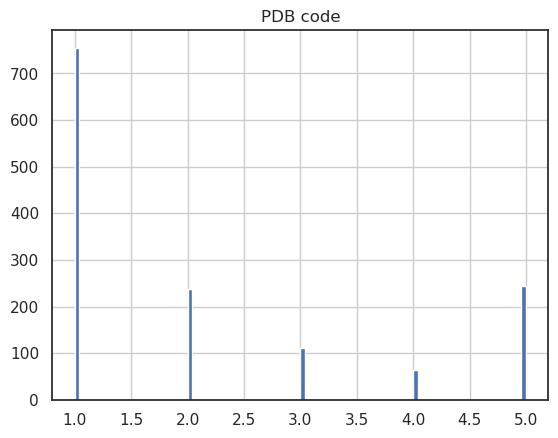

In [199]:
my_csv_group.hist(bins = 100)

In [200]:
data_sliced = my_csv[my_csv['Protein name'].isin(list(my_csv_group[my_csv_group['PDB code']>4]['Protein name']))]

In [201]:
data_sliced.groupby('Protein name')[['PDB code']].nunique().reset_index().sort_values('PDB code')

,Protein name,PDB code
0,"1,3-BETA-GLUCANOSYLTRANSFERASE GAS2",5
155,MITOGEN-ACTIVATED PROTEIN KINASE 14,5
156,MTA/SAH NUCLEOSIDASE,5
157,N-ACETYLGLUCOSAMINIDASE,5
158,N-METHYL-D-ASPARTATE RECEPTOR SUBUNIT 1,5
...,...,...
86,DIHYDROPTEROATE SYNTHASE,5
87,DIPEPTIDYL PEPTIDASE 4,5
88,DNA POLYMERASE III SUBUNIT BETA,5
90,DUAL SPECIFICITY PROTEIN KINASE TTK,5


In [202]:
family_counts = defaultdict(list)

# Count the occurrences of each family
family_counts = defaultdict(list)
for d in filtered_data_list:
    family_counts[d.pdb].append(d)

In [203]:
family_counts['4ogj']

[BipartiteData(edge_index=[2, 99], x_s=[99, 12], x_t=[99, 12], y=0.0, edge_attr=[99], num_nodes=198, pdb='4ogj', pose=3),
 BipartiteData(edge_index=[2, 72], x_s=[72, 12], x_t=[72, 12], y=0.0, edge_attr=[72], num_nodes=144, pdb='4ogj', pose=8),
 BipartiteData(edge_index=[2, 84], x_s=[84, 12], x_t=[84, 12], y=0.0, edge_attr=[84], num_nodes=168, pdb='4ogj', pose=2),
 BipartiteData(edge_index=[2, 66], x_s=[66, 12], x_t=[66, 12], y=0.0, edge_attr=[66], num_nodes=132, pdb='4ogj', pose=10),
 BipartiteData(edge_index=[2, 108], x_s=[108, 12], x_t=[108, 12], y=0.0, edge_attr=[108], num_nodes=216, pdb='4ogj', pose=1),
 BipartiteData(edge_index=[2, 73], x_s=[73, 12], x_t=[73, 12], y=0.0, edge_attr=[73], num_nodes=146, pdb='4ogj', pose=9),
 BipartiteData(edge_index=[2, 98], x_s=[98, 12], x_t=[98, 12], y=0.0, edge_attr=[98], num_nodes=196, pdb='4ogj', pose=4),
 BipartiteData(edge_index=[2, 74], x_s=[74, 12], x_t=[74, 12], y=0.0, edge_attr=[74], num_nodes=148, pdb='4ogj', pose=5),
 BipartiteData(edge

In [204]:
new_list_only_more_than_2_per_family = []
for pdb, instance in family_counts.items():
    if pdb in list(data_sliced['PDB code'].unique()):
        new_list_only_more_than_2_per_family.extend(instance)

In [205]:
random.shuffle(new_list_only_more_than_2_per_family)

#### Saving datalist  endoded and randomized

In [206]:
for data in filtered_data_list:
    print(data)
    print(data.x_s)
    break

BipartiteData(edge_index=[2, 81], x_s=[81, 12], x_t=[81, 12], y=0.0, edge_attr=[81], num_nodes=162, pdb='3ao4', pose=4)
tensor([[0.0000, 2.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0255, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 2.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0255, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0255, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0255, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 2.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0255, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 2.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0255, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 2.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0255, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 2.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0255, 1.0000, 0.

In [207]:
save_list_to_file(filtered_data_list, config, f"{name_encoded}.pkl")

Saved bipartite_rank_cut_4_REFINED_RAND_POSERANKtype2.pkl with success!


tensor([[0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 2., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 2., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 2

#### Saving datalist  endoded and randomized AND reduced 

In [126]:
filtered_data_list = [data for data in filtered_data_list if data.pdb in order_dataset_that_works]

In [127]:
save_list_to_file(filtered_data_list, config, f"{name_encoded}_3_plus.pkl")

Saved bipartite_no_pose_rank_cut_4_REFINED_RAND_ENCODED_POSERANK_3_plus.pkl with success!


In [130]:
dict(Counter([d.y.tolist() for d in filtered_data_list]))

{0.0: 1237, 1.0: 111}

In [1]:
1237 + 111

1348

#### Testing LP

In [132]:
len(filtered_data_list)

1348

In [134]:
1348 - (1348 * 0.3)

943.6

In [ ]:
bipartite_data_not_encode_RANDON_3000 = random.sample(bipartite_data_not_encode_RANDON, 1900)

In [ ]:
bipartite_data_not_encode_RANDON_3000_ORDERED = sorted(bipartite_data_not_encode_RANDON, key=pdb_index)
bipartite_data_not_encode_RANDON_3000_ORDERED = random.sample(bipartite_data_not_encode_RANDON_3000_ORDERED, 1900)

In [ ]:
#### Taking best and worst
#dict(Counter([data.y.tolist() for data in bipartite_data_not_encode_RANDON]))

In [ ]:
#bipartite_data_not_encode_RANDON_slice = [data for data in bipartite_data_not_encode_RANDON if data.pose in [1, 2, 9, 10]]

In [ ]:
len(bipartite_data_not_encode_RANDON_3000)

In [ ]:
dict(Counter([data.y.tolist() for data in bipartite_data_not_encode_RANDON_3000]))

In [ ]:
2760/240

In [ ]:
len(bipartite_data_not_encode_RANDON_3000_ORDERED)

In [ ]:
#save_list_to_file(bipartite_data_not_encode_RANDON_3000_ORDERED, config, f"{file_to_randomize}_RAND_3000_ORDERED.pkl")

# SOLVING BUG

#### Dataset the works 

In [7]:
working = open_file(config, "bipartite_data_no_pose_rank_NOT_sorted_by_family_cut_4_coreset_1_RAND.pkl")

In [8]:
order_dataset_that_works = []
for data in working:
    order_dataset_that_works.append(data.pdb)

#### Dataset that does not work 

In [9]:
fail = open_file(config, "bipartite_data_no_pose_rank_cut_4_refined_set_encoded_RAND.pkl")

In [10]:
def pdb_index(item):
    try:
        return order_dataset_that_works.index(item.pdb)
    except ValueError:
        return float('inf')  # Return a very large value if PDb not found

In [11]:
fail = [data for data in fail if data.pdb not in order_dataset_that_works]

In [12]:
len(fail)

26303

In [169]:
len(working)

1948

In [170]:
working = filter_and_print_label_distribution(working)

Label Distribution:
Label 0.0: 1802
Label 1.0: 146
Amount of Graphs Used to Train: 1948


In [172]:
fail = filter_and_print_label_distribution(fail)

Label Distribution:
Label 0.0: 24205
Label 1.0: 2098
Amount of Graphs Used to Train: 26303


In [173]:
fail = sorted(fail, key =  lambda item : item.pdb)

In [174]:
fail = fail[:1948]

In [179]:
dict(Counter([data.y.tolist() for data in fail]))

{0.0: 1809, 1.0: 139}

In [158]:
random.shuffle(fail)

In [162]:
fail = filter_and_print_label_distribution(fail)

Label Distribution:
Label 0.0: 1809
Label 1.0: 139
Amount of Graphs Used to Train: 1948


In [183]:
#save_list_to_file(fail, config, f"{file_to_randomize}_RANDOM_FAIL_DIFFERENT_COMPLEXES.pkl")

#### Comparing data 

In [ ]:
first_list = bipartite_data_shuffle
second_list = bipartite_data_not_encode

In [ ]:
second_list = [dato for dato in second_list if dato.pdb !="2c3i"]
index_map = {(item.pdb, item.pose): i for i, item in enumerate(first_list)}
second_list_reordered = [first_list[index_map[(item.pdb, item.pose)]] for item in second_list]

In [ ]:
# Comparing every aspect of the two sorted lists
for data1, data2 in zip(first_list, second_list_reordered):
    if data1.pdb != data2.pdb:
        print("pdb:", data1.pdb == data2.pdb)
    if data1.pose != data2.pose:
        print("pose:", data1.pose == data2.pose)
    if data1.y != data2.y:
        print("y:", data1.y == data2.y)
    if data1.num_nodes != data2.num_nodes:
        print("num_nodes:", data1.num_nodes == data2.num_nodes)
    if not torch.equal(data1.edge_attr, data2.edge_attr):
        print("edge_attr:", torch.equal(data1.edge_attr, data2.edge_attr))
    if not torch.equal(data1.edge_index, data2.edge_index):
        print("edge_index:", torch.equal(data1.edge_index, data2.edge_index))
    if not torch.equal(data1.x_s, data2.x_s):
        print("x_s:", torch.equal(data1.x_s, data2.x_s))
    if not torch.equal(data1.x_t, data2.x_t):
        print("x_t:", torch.equal(data1.x_t, data2.x_t))

##### Discussion

In [ ]:
0.6786

In [6]:
import numpy as np

In [7]:
m = np.array(m)

In [8]:
m*0.67

array([[0.  , 2.01, 2.01, 0.67, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 2.01, 1.34, 0.  , 0.  , 0.  ],
       [0.  , 2.01, 2.01, 0.67, 0.  , 0.  , 0.  ]])